In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, auc, roc_curve
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
def find_best_threshold_f1_score(train_labels, oofs, average='macro'):
    scores = []
    thresholds = []
    best_score = 0
    best_threshold = 0
    for threshold in np.arange(0.1, 0.9, 0.01):
        print(f'{threshold:.02f}, ', end='')
        preds = (oofs > threshold).astype('int')
        m = f1_score(train_labels, preds, average=average)
        scores.append(m)
        thresholds.append(threshold)
        if m > best_score:
            best_score = m
            best_threshold = threshold
    return best_threshold, best_score

In [3]:
with open(f"../checkpoints/nothing_model_200_estimators.pkl", "rb") as f:
    nothing_loadded = pickle.load(f)
with open(f"../checkpoints/smote_model_200_estimators.pkl", "rb") as f:
    smote_loadded = pickle.load(f)
with open(f"../checkpoints/class_weight_model_200_estimators.pkl", "rb") as f:
    class_weight_loadded = pickle.load(f)
with open(f"../checkpoints/under_sampling_model_200_estimators.pkl", "rb") as f:
    under_sampling_loadded = pickle.load(f)
with open("../checkpoints/nothing_ensemble.pkl", "rb") as f:
    nothing_ensemble_loadded = pickle.load(f)
with open("../checkpoints/smote_ensemble.pkl", "rb") as f:
    smote_ensemble_loadded = pickle.load(f)
with open("../checkpoints/under_sampling_ensemble.pkl", "rb") as f:
    under_sampling_ensemble_loadded = pickle.load(f)
test = pd.read_parquet("../data/test.parquet")
train = pd.read_parquet("../data/train.parquet")

In [20]:
MODEL_NAMES = ['lr', 'rf', 'lgb', 'xgb', 'mlp', 'blend', 'stack']
nothing_score_df = nothing_loadded['score_df']
nothing_oofs = nothing_loadded['oofs']
nothing_models = nothing_loadded['models']
nothing_predictions = nothing_loadded['predictions']

smote_score_df = smote_loadded['score_df']
smote_oofs = smote_loadded['oofs']
smote_models = smote_loadded['models']
smote_predictions = smote_loadded['predictions']

class_weight_score_df = class_weight_loadded['score_df']
class_weight_oofs = class_weight_loadded['oofs']
class_weight_df_models = class_weight_loadded['models']
class_weight_predictions = class_weight_loadded['predictions']

under_sampling_score_df = under_sampling_loadded['score_df']
under_sampling_oofs = under_sampling_loadded['oofs']
under_sampling_models = under_sampling_loadded['models']
under_sampling_predictions = under_sampling_loadded['predictions']


nothing_ensemble_score_df = nothing_ensemble_loadded['score_df']
nothing_ensemble_predictions = nothing_ensemble_loadded['predictions']

smote_ensemble_score_df = smote_ensemble_loadded['score_df']
smote_ensemble_predictions = smote_ensemble_loadded['predictions']

under_sampling_ensemble_score_df = under_sampling_ensemble_loadded['score_df']
under_sampling_ensemble_predictions = under_sampling_ensemble_loadded['predictions']

In [21]:
nothing_score_df = pd.concat([nothing_score_df,nothing_ensemble_score_df], axis=0).reset_index(drop=True)
smote_score_df = pd.concat([smote_score_df,smote_ensemble_score_df],axis=0).reset_index(drop=True)
under_sampling_score_df = pd.concat([under_sampling_score_df, under_sampling_ensemble_score_df], axis=0).reset_index(drop=True)

In [22]:
smote_ensemble_score_df

,model_name,accuracy_score,f1_score,auc_score,specificity_score,sensitivity_score
0,blend,0.817555,0.769320,0.892058,0.843845,0.736377
1,stack,0.828810,0.778749,0.898497,0.863471,0.721784


In [23]:
nothing_ensemble_score_df

,model_name,accuracy_score,f1_score,auc_score,specificity_score,sensitivity_score
0,blend,0.821440,0.772846,0.889543,0.849888,0.733598
1,stack,0.829935,0.782098,0.899974,0.859499,0.738646


In [24]:
y_test = test['churn_user']

In [25]:
import matplotlib
font = {'size'   : 25}
matplotlib.rc('font', **font)

def gen_data(model_name='xgb'):
    x0 = nothing_score_df[nothing_score_df.model_name==model_name]
    x0['method'] = 'not_handle'
    x1 = smote_score_df[smote_score_df.model_name==model_name]
    x1['method'] = 'smote'
    x2 = class_weight_score_df[class_weight_score_df.model_name==model_name]
    x2['method'] = 'class_weight'
    x3 = under_sampling_score_df[under_sampling_score_df.model_name==model_name]
    x3['method'] = 'under_sampling' 
    scores = pd.concat([x0, x1, x2, x3])
    return scores 
def plot_handle_imbalanced(model_name, title):
    scores = gen_data(model_name)
    fig, axes = plt.subplots(3, 2, figsize=(30,30))
    sns.barplot(x='method', y='accuracy_score', data=scores, ax=axes[0,0])
    for i, val in enumerate(scores['accuracy_score'].values):
        axes[0,0].text(i-0.2, val+0.01, round(val, 4))
    axes[0,0].set_ylim(0,1)
    axes[0,0].set_title("accuracy score")

    sns.barplot(x='method', y='f1_score', data=scores, ax=axes[0,1])
    for i, val in enumerate(scores['f1_score'].values):
        axes[0,1].text(i-0.2, val+0.01, round(val, 4))
    axes[0,1].set_ylim(0,1)
    axes[0,1].set_title("f1-score")

    sns.barplot(x='method', y='auc_score', data=scores, ax=axes[1,0])
    for i, val in enumerate(scores['auc_score'].values):
        axes[1,0].text(i-0.2, val+0.01, round(val, 4))
    axes[1,0].set_ylim(0,1)
    axes[1,0].set_title("auc score")

    sns.barplot(x='method', y='specificity_score', data=scores, ax=axes[1,1])
    for i, val in enumerate(scores['specificity_score'].values):
        axes[1,1].text(i-0.2, val+0.01, round(val, 4))
    axes[1,1].set_ylim(0,1)
    axes[1,1].set_title("specificity score")

    sns.barplot(x='method', y='sensitivity_score', data=scores, ax=axes[2,0])
    for i, val in enumerate(scores['sensitivity_score'].values):
        axes[2, 0].text(i-0.2, val+0.01, round(val, 4))
    axes[2, 0].set_ylim(0,1)
    axes[2, 0].set_title("sensitivity score")
    plt.suptitle(title)
    plt.tight_layout()
    return fig

In [160]:
# log_reg_fig = plot_handle_imbalanced(MODEL_NAMES[0], "Logistic Regression")
# rf_fig = plot_handle_imbalanced(MODEL_NAMES[1], "Random Forest")
# lightgbm_fig = plot_handle_imbalanced(MODEL_NAMES[2], "Lightgbm")
# xgboost_fig = plot_handle_imbalanced(MODEL_NAMES[3], "Xgboost")
# mlp_fig = plot_handle_imbalanced(MODEL_NAMES[4], "MLP")

In [26]:
under_sampling_score_df

,model_name,accuracy_score,f1_score,auc_score,specificity_score,sensitivity_score
0,log_reg,0.823995,0.768257,0.882216,0.870050,0.681785
1,randomforest,0.822665,0.766191,0.890303,0.869858,0.676941
2,lightgbm,0.834845,0.786432,0.904813,0.867760,0.733209
3,xgboost,0.836140,0.787044,0.904852,0.871288,0.727609
4,mlp,0.836010,0.781411,0.900954,0.884196,0.687222
5,blend,0.826010,0.771717,0.890941,0.869567,0.691514
6,stack,0.833930,0.779842,0.899027,0.880092,0.691391


In [27]:
nothing_score_df['model_name'] = MODEL_NAMES
class_weight_score_df['model_name'] = MODEL_NAMES[:-2]
smote_score_df['model_name'] = MODEL_NAMES
under_sampling_score_df['model_name'] = MODEL_NAMES

In [28]:
nothing_score_df

,model_name,accuracy_score,f1_score,auc_score,specificity_score,sensitivity_score
0,lr,0.821340,0.766071,0.882068,0.865410,0.685259
1,rf,0.820295,0.767212,0.890830,0.859062,0.700589
2,lgb,0.835630,0.786650,0.905045,0.870282,0.728631
3,xgb,0.836640,0.787484,0.905264,0.872142,0.727016
4,mlp,0.831910,0.782919,0.900963,0.865119,0.729367
5,blend,0.821440,0.772846,0.889543,0.849888,0.733598
6,stack,0.829935,0.782098,0.899974,0.859499,0.738646


In [29]:
class_weight_score_df['method'] = 'class weight'
nothing_score_df['method'] = 'no handle'
smote_score_df['method'] = 'smote'
under_sampling_score_df['method'] = 'under sampling'

In [30]:
class_weight_score_df.iloc[4,1:-1] = 0

In [31]:
class_weight_score_df

,model_name,accuracy_score,f1_score,auc_score,specificity_score,sensitivity_score,method
0,lr,0.826060,0.768361,0.882136,0.877153,0.668295,class weight
1,rf,0.820115,0.765986,0.889325,0.861207,0.693231,class weight
2,lgb,0.835305,0.786796,0.904845,0.868647,0.732351,class weight
3,xgb,0.836320,0.787337,0.905244,0.871262,0.728427,class weight
4,mlp,0.000000,0.000000,0.000000,0.000000,0.000000,class weight


In [32]:
x = pd.concat([nothing_score_df,class_weight_score_df,smote_score_df,under_sampling_score_df])
# x.set_index(['method','model_name']).transpose().to_csv('../outputs/data2.csv')

In [12]:
x[['model_name', 'method']+list(x.columns[1:-1])].to_csv('../outputs/data3.csv')

lr


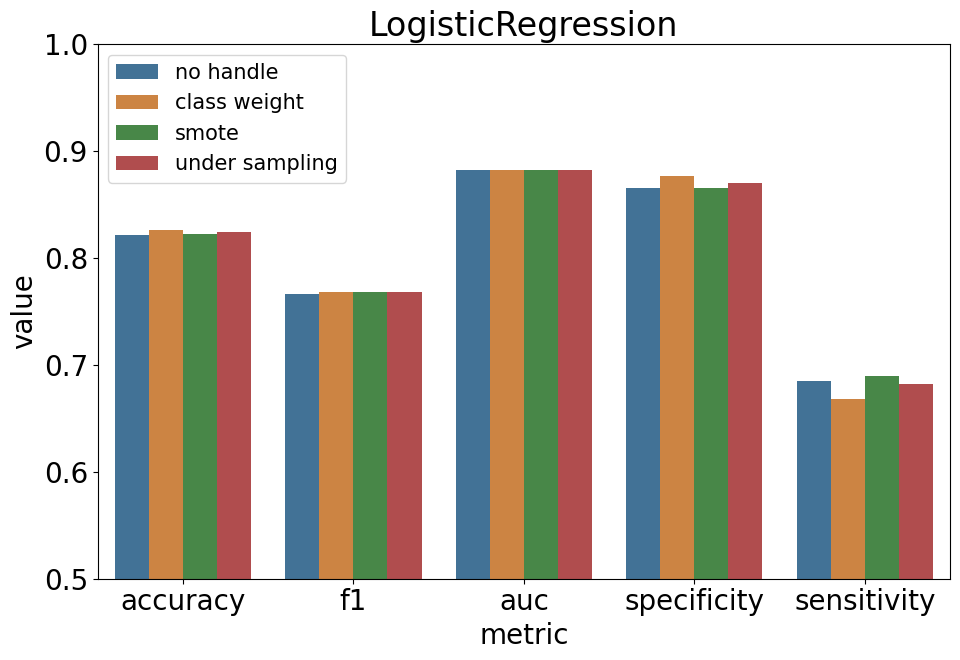

In [43]:
font = {'size'   : 20}
matplotlib.rc('font', **font)
x_plot = x.melt(id_vars=['model_name', 'method'], value_vars=x.columns[1:-1])
x_plot['metric'] = x_plot['variable'].str.split('_').str.get(0)
x_plot = x_plot[x_plot.value>0]
def plot_handle_imbalanced(model_name='lr', title="", palette=None):
    print(model_name)
    fig = plt.figure(figsize=(10,7))
    sns.barplot(x='metric', y='value', hue='method',data=x_plot[x_plot.model_name==model_name], palette=palette)
    plt.ylim(0.5,1)
    # plt.legend(bbox_to_anchor=(0.63, -0.2))
    plt.legend(loc="upper left",prop={'size': 15})
    plt.title(title)
    plt.tight_layout()

    return fig
lr_fig = plot_handle_imbalanced(MODEL_NAMES[0], 'LogisticRegression',palette=["#3474a4","#e3832c", "#3d923d","#c03d3e"])
lr_fig.savefig('../outputs/h_lr.png')

rf


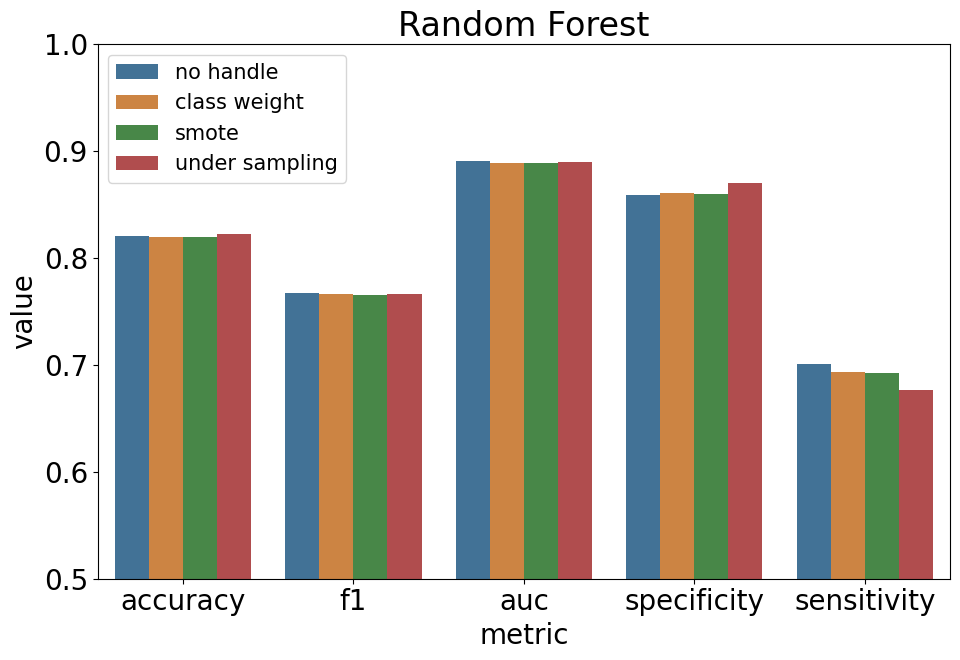

In [44]:
rf_fig = plot_handle_imbalanced(MODEL_NAMES[1], 'Random Forest',palette=["#3474a4","#e3832c", "#3d923d","#c03d3e"])
rf_fig.savefig('../outputs/h_rf.png')

lgb


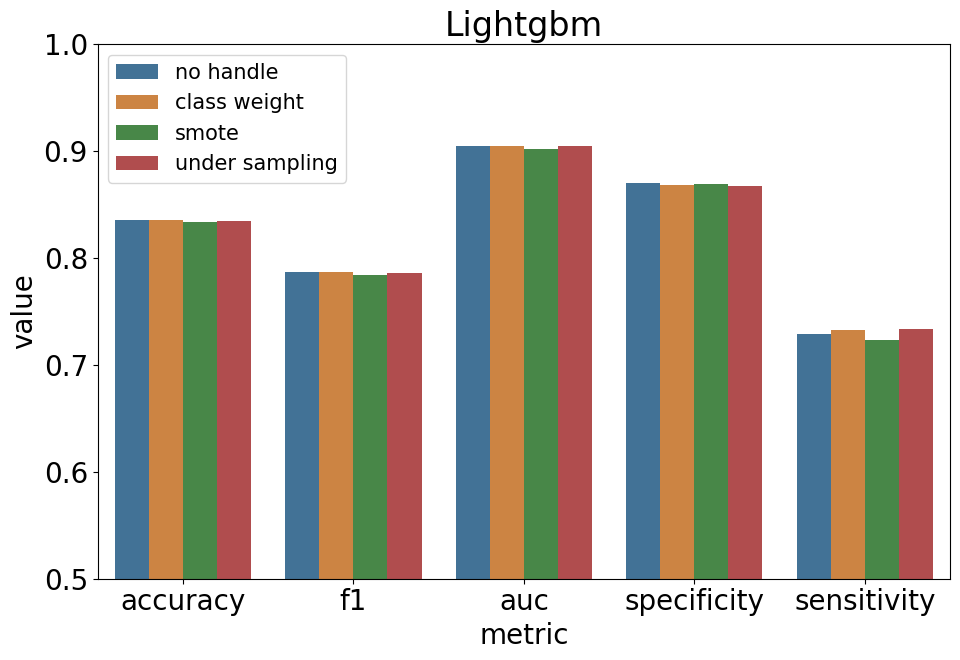

In [45]:
lgb_fig = plot_handle_imbalanced(MODEL_NAMES[2], 'Lightgbm',palette=["#3474a4","#e3832c", "#3d923d","#c03d3e"])
lgb_fig.savefig('../outputs/h_lgb.png')

xgb


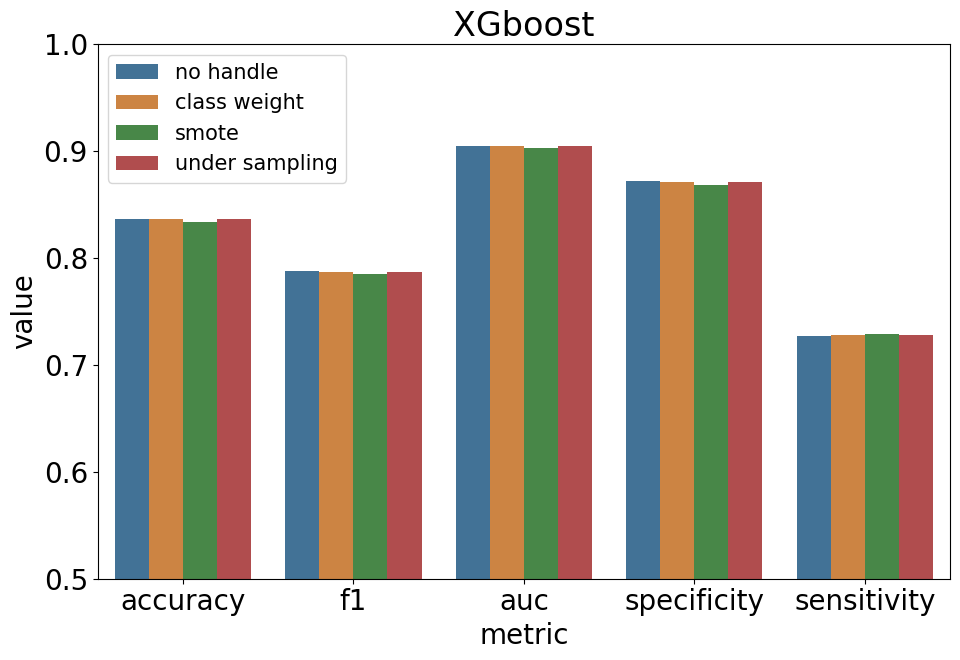

In [46]:
xgb_fig = plot_handle_imbalanced(MODEL_NAMES[3], 'XGboost',palette=["#3474a4","#e3832c", "#3d923d","#c03d3e"])
xgb_fig.savefig('../outputs/h_xgb.png')

mlp


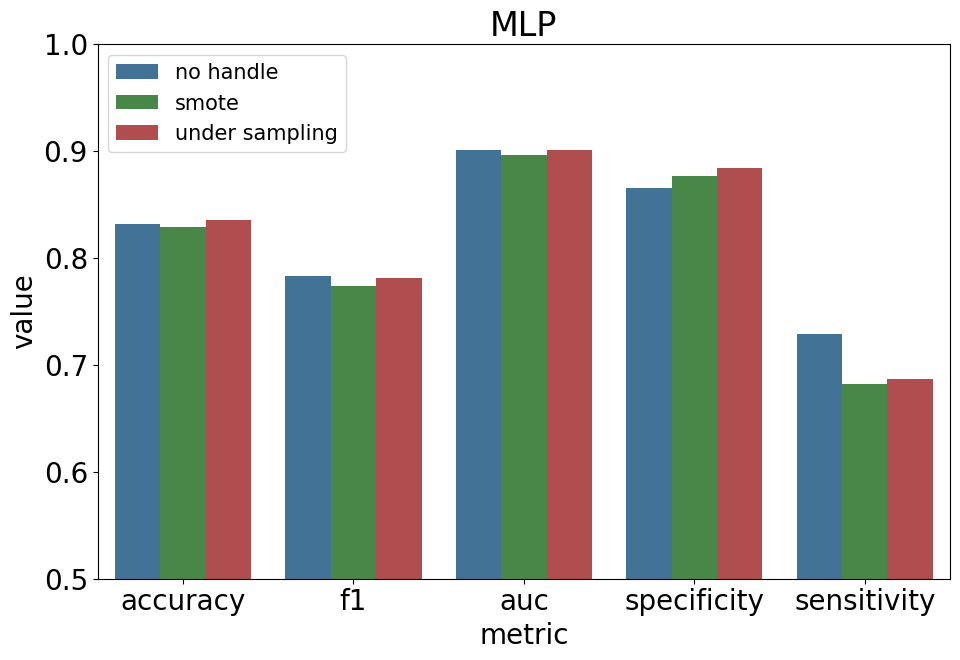

In [48]:
mlp_fig = plot_handle_imbalanced(MODEL_NAMES[4], 'MLP',palette=["#3474a4", "#3d923d","#c03d3e"])
mlp_fig.savefig('../outputs/h_mlp.png')

blend


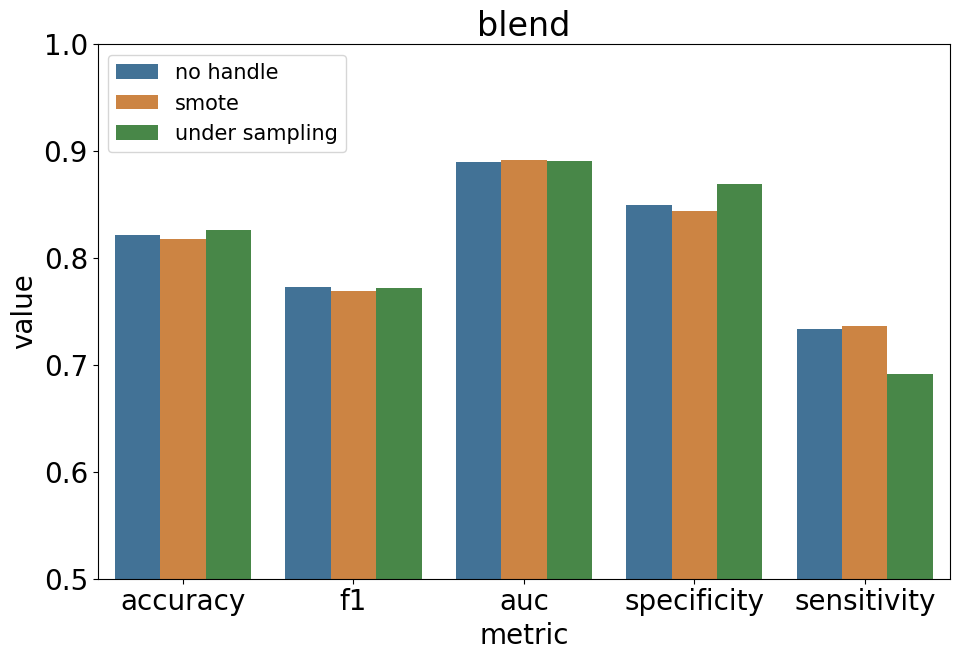

In [49]:
mlp_fig = plot_handle_imbalanced(MODEL_NAMES[5], 'blend', palette=["#3474a4","#e3832c", "#3d923d","#c03d3e"])
mlp_fig.savefig('../outputs/h_blend.png')

stack


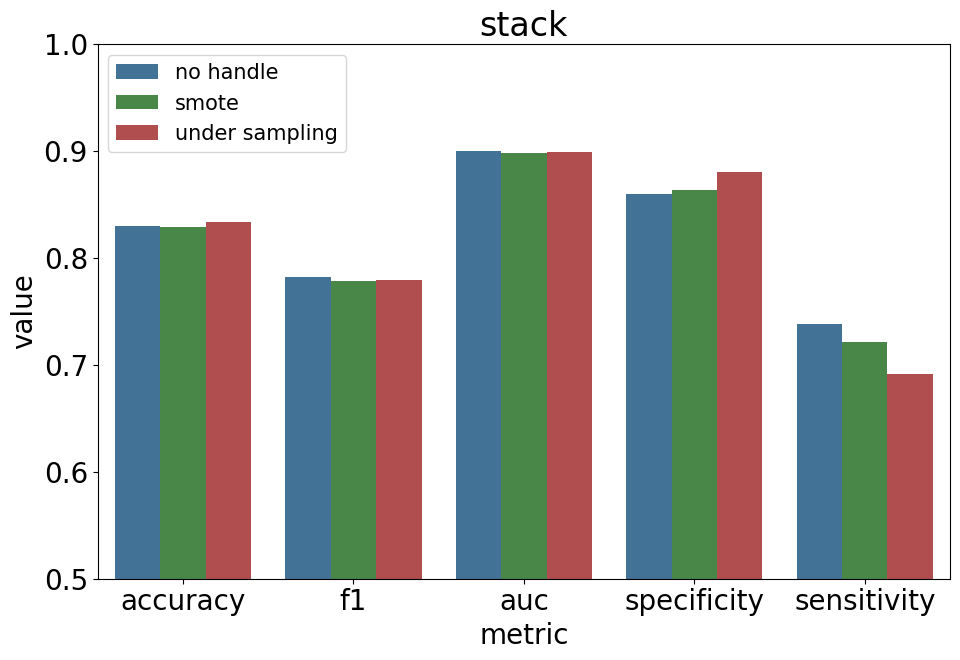

In [51]:
mlp_fig = plot_handle_imbalanced(MODEL_NAMES[6], 'stack', palette=["#3474a4", "#3d923d","#c03d3e"])
mlp_fig.savefig('../outputs/h_stack.png')

In [52]:
def plot_roc_curve(y_true, y_pred_prob, show_threshold=False, **params):
    """
        A function plot Roc AUC.
                Parameters:
                            y_true: Array
                                True label
                            y_pred_prob: Array
                                Probability predicted label
                            show_threshold: Bool
                                Show threshold
                Returns:
                            figure: Figure
                            roc_auc: AUC value
    """

    figure = plt.figure(figsize=params.get('figsize', (17, 10)))
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.5f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    if show_threshold:
        ax2 = plt.gca().twinx()
        ax2.plot(fpr, thresholds, markeredgecolor='r',
                 linestyle='dashed', color='r')
        ax2.set_ylabel('Threshold', color='r')
        ax2.set_ylim([0.0, 1.0])
        ax2.set_xlim([0.0, 1.0])

    plt.show()

    return figure, roc_auc


def plot_multi_roc_curve(y_trues, y_pred_probs, labels, title="",**params):
    """
        A function plot Roc AUC.
                Parameters:
                            y_trues: Array of Array
                                True label
                            y_pred_probs: Array of Array
                                Probability predicted label
                            labels: List
                                List of label
                Returns:
                            figure: Figure
                            roc_aucs: List AUC value
    """

    figure = plt.figure(figsize=params.get('figsize', (12, 10)))
    roc_aucs = []
    for y_true, y_pred_prob, label in zip(y_trues, y_pred_probs, labels):
        fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        roc_aucs.append(roc_auc)
        plt.plot(fpr, tpr, label=f'{label} ROC curve (area = %0.5f)' % roc_auc)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve {title}')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    return figure, roc_aucs

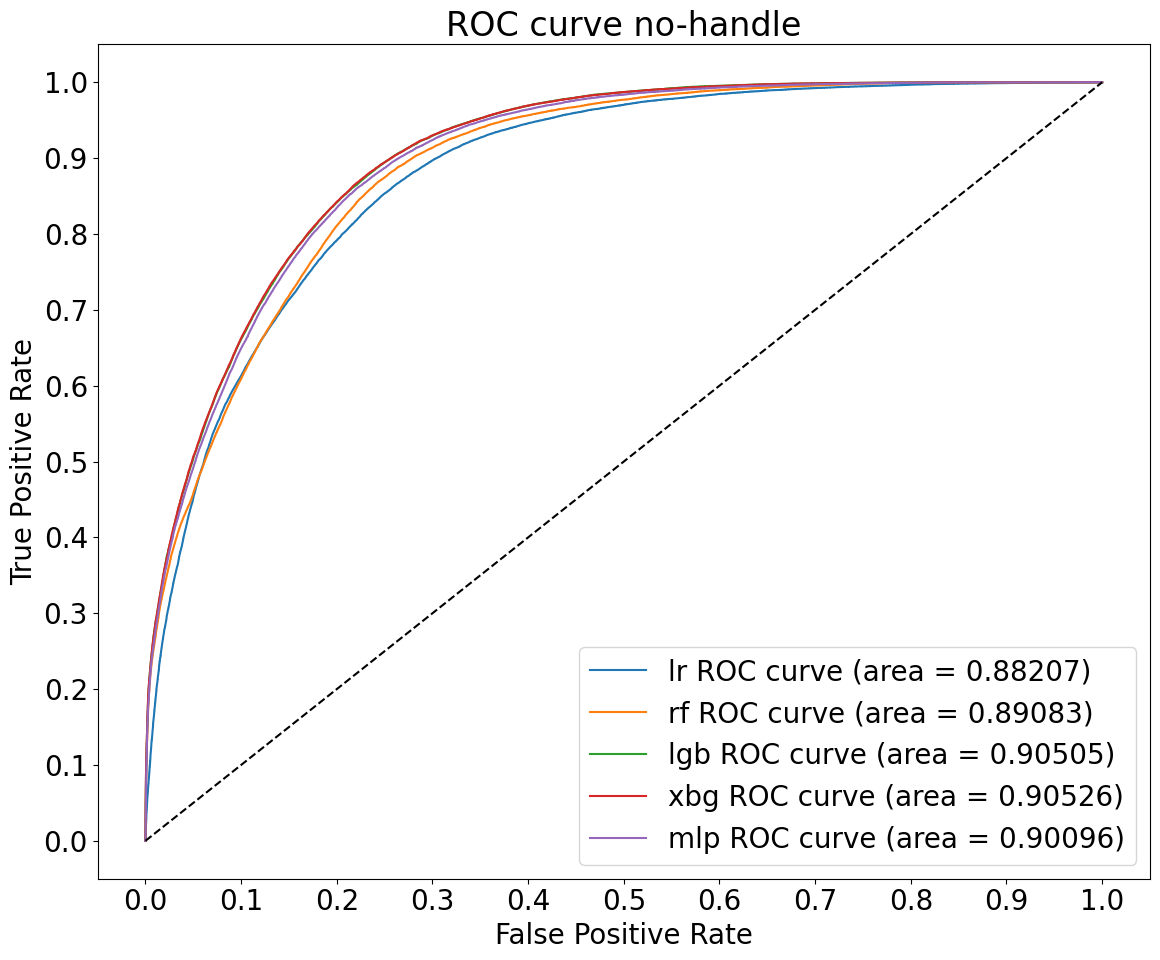

In [53]:
fig,_ = plot_multi_roc_curve([y_test,y_test,y_test,y_test,y_test], nothing_predictions, title='no-handle',labels=['lr', 'rf','lgb', 'xbg', 'mlp'])
fig.savefig('../outputs/roc_no_handle.png')

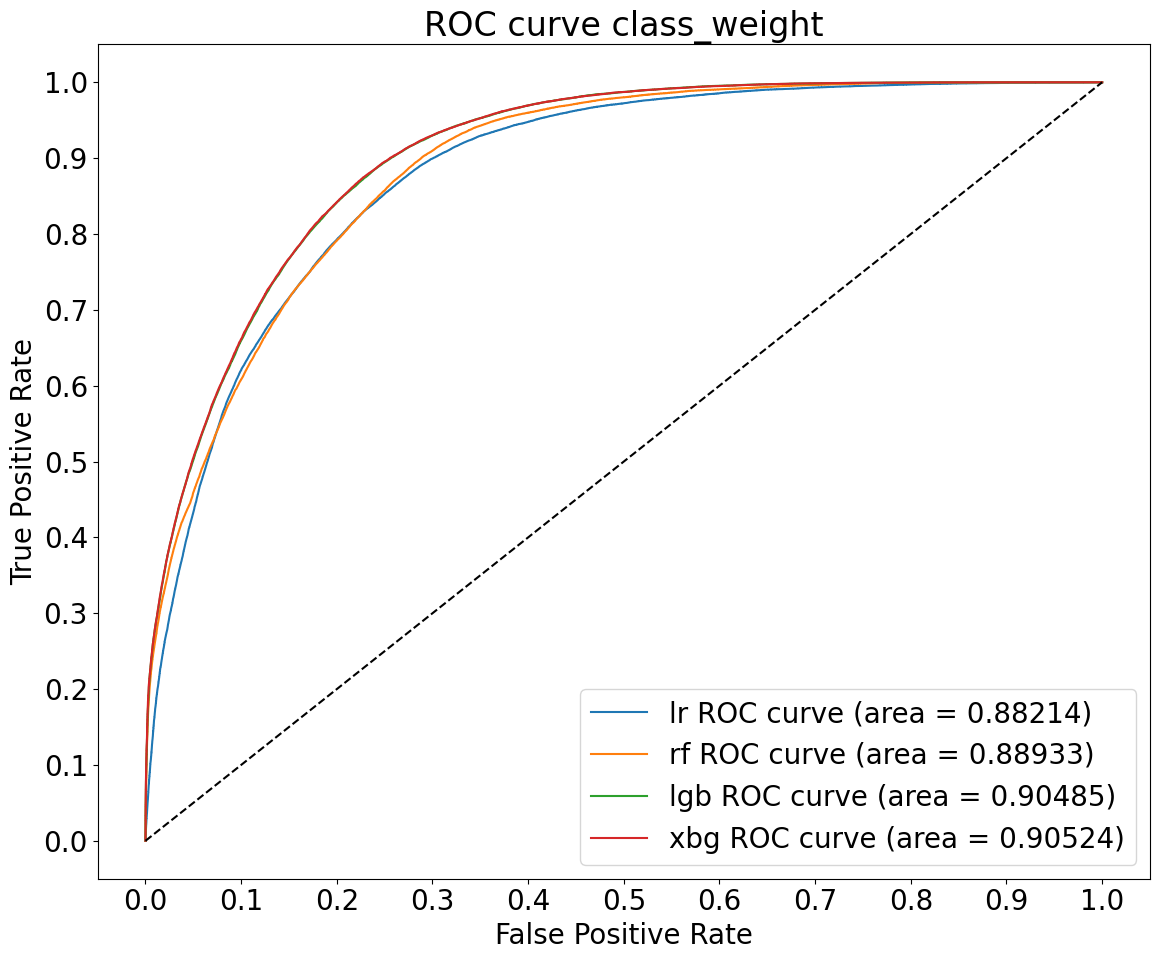

In [54]:
fig, _ = plot_multi_roc_curve([y_test,y_test,y_test,y_test], class_weight_predictions, title='class_weight',labels=['lr', 'rf','lgb', 'xbg', 'mlp'])
fig.savefig('../outputs/roc_class_weight.png')

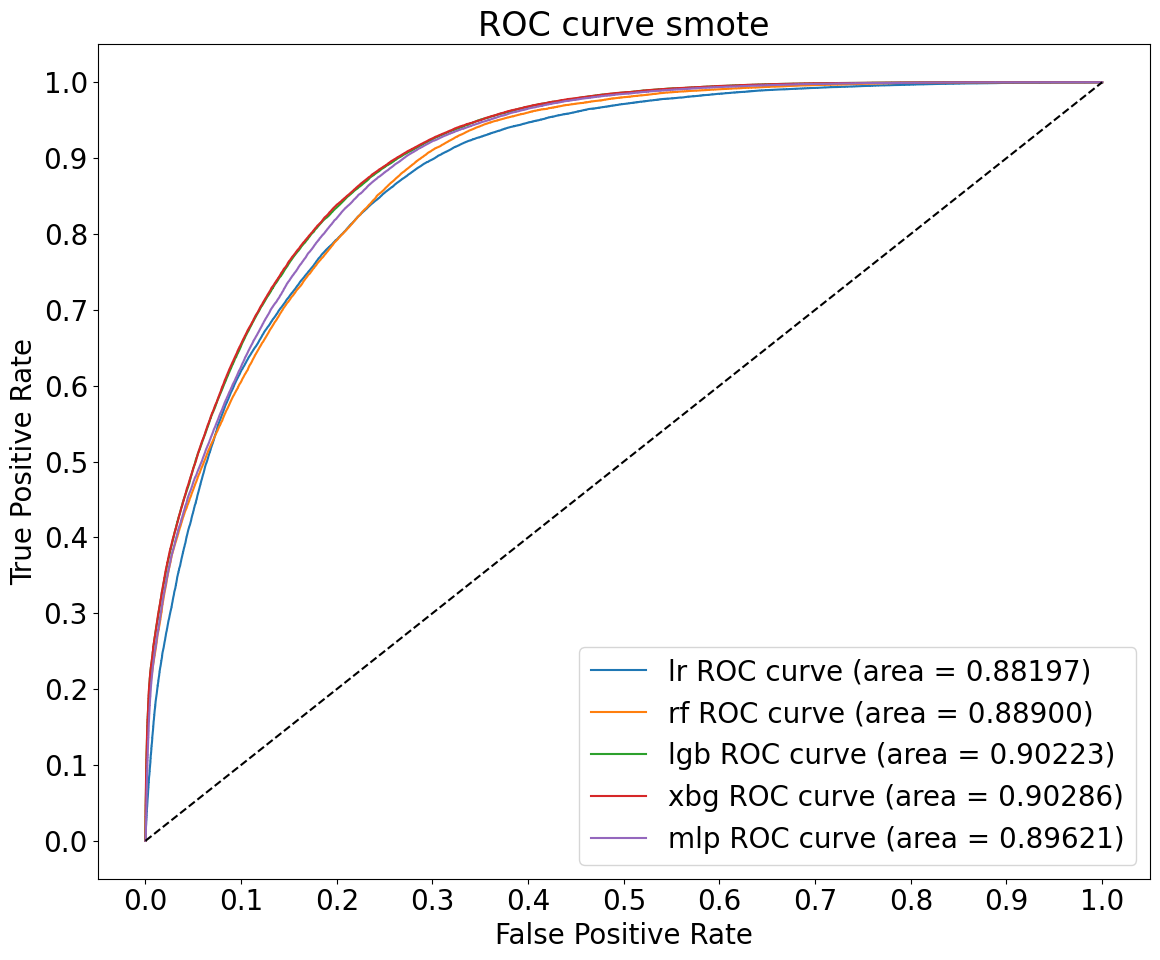

In [56]:
fig, _ = plot_multi_roc_curve([y_test,y_test,y_test,y_test,y_test], smote_predictions, title='smote',labels=['lr', 'rf','lgb', 'xbg', 'mlp'])
fig.savefig('../outputs/roc_smote.png')

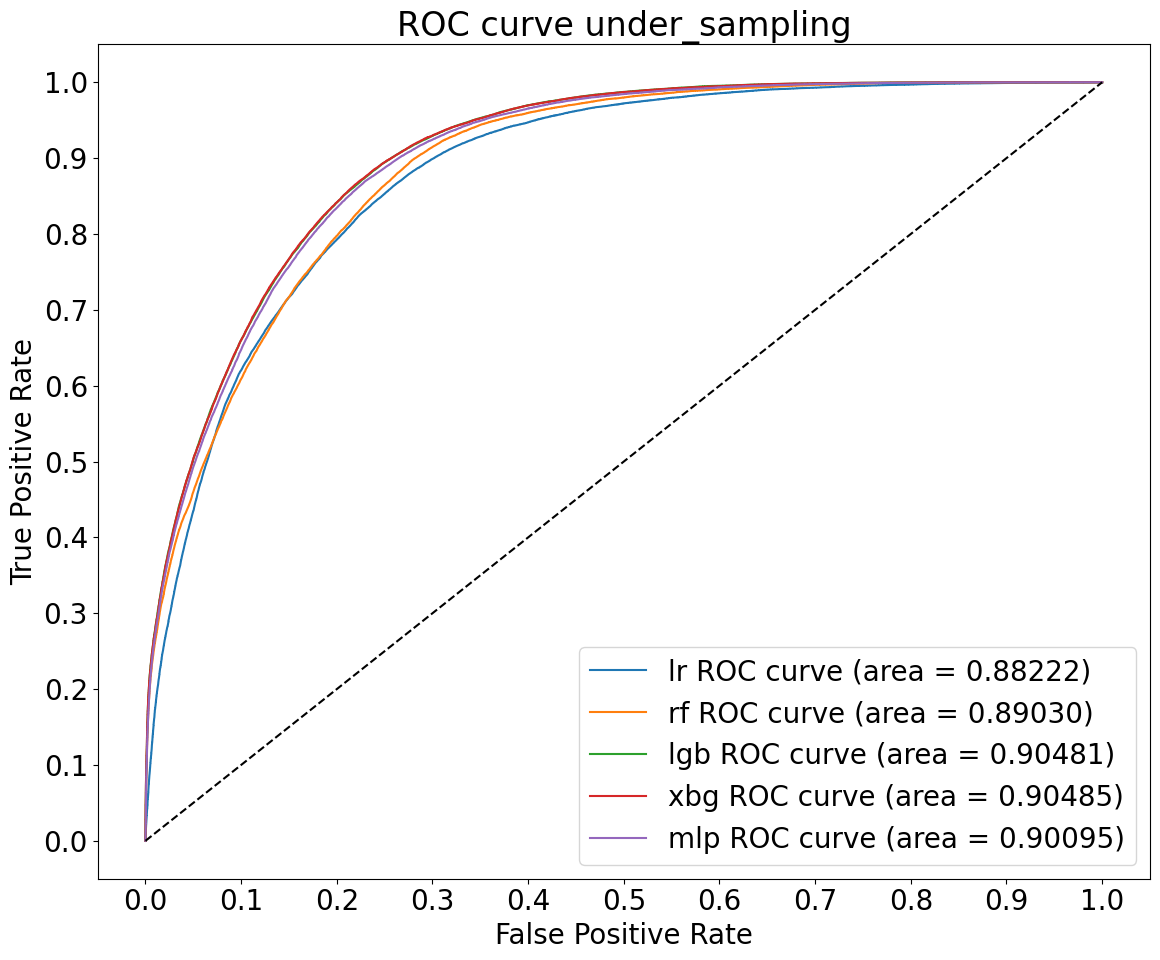

In [57]:
fig, _ = plot_multi_roc_curve([y_test,y_test,y_test,y_test,y_test], under_sampling_predictions, title='under_sampling',labels=['lr', 'rf','lgb', 'xbg', 'mlp'])
fig.savefig('../outputs/roc_under_sampling.png')